In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import json

# Load Data Pada CSV dan Proses menjadi Data Time Series

In [2]:
#Load data csv dan format data tahun bulan menjadi data frame
df = pd.read_csv('DATASET_PAJAK_AIR_TANAH.csv')
df['tahun'] = pd.to_datetime(df['tahun_bulan'])
df.head()

,tahun_bulan,jml_setor,tahun
0,2011-1,14587749,2011-01-01
1,2011-2,14587749,2011-02-01
2,2011-3,87590962,2011-03-01
3,2011-4,61913147,2011-04-01
4,2011-5,41762998,2011-05-01


In [4]:
#Buat data tiemseries berdasar key value dari data frame
dts = pd.Series(data=df['jml_setor'].values, index=df['tahun'])
dts.head()

json_data = dts.to_json(date_format='iso')
print(json_data)
with open('./datasets/airtanah.json', 'w') as f:
    json.dump(json_data, f) 

{"2011-01-01T00:00:00.000":14587749,"2011-02-01T00:00:00.000":14587749,"2011-03-01T00:00:00.000":87590962,"2011-04-01T00:00:00.000":61913147,"2011-05-01T00:00:00.000":41762998,"2011-06-01T00:00:00.000":80390936,"2011-07-01T00:00:00.000":92002154,"2011-08-01T00:00:00.000":68491305,"2011-09-01T00:00:00.000":80852180,"2011-10-01T00:00:00.000":66817745,"2011-11-01T00:00:00.000":115702331,"2011-12-01T00:00:00.000":68238888,"2012-01-01T00:00:00.000":57332151,"2012-02-01T00:00:00.000":90925751,"2012-03-01T00:00:00.000":73466595,"2012-04-01T00:00:00.000":52951721,"2012-05-01T00:00:00.000":94084548,"2012-06-01T00:00:00.000":76445639,"2012-07-01T00:00:00.000":67069716,"2012-08-01T00:00:00.000":79563420,"2012-09-01T00:00:00.000":76693418,"2012-10-01T00:00:00.000":95330689,"2012-11-01T00:00:00.000":98332469,"2012-12-01T00:00:00.000":72608479,"2013-01-01T00:00:00.000":101731325,"2013-02-01T00:00:00.000":72919750,"2013-03-01T00:00:00.000":86124005,"2013-04-01T00:00:00.000":93015868,"2013-05-01T00:00

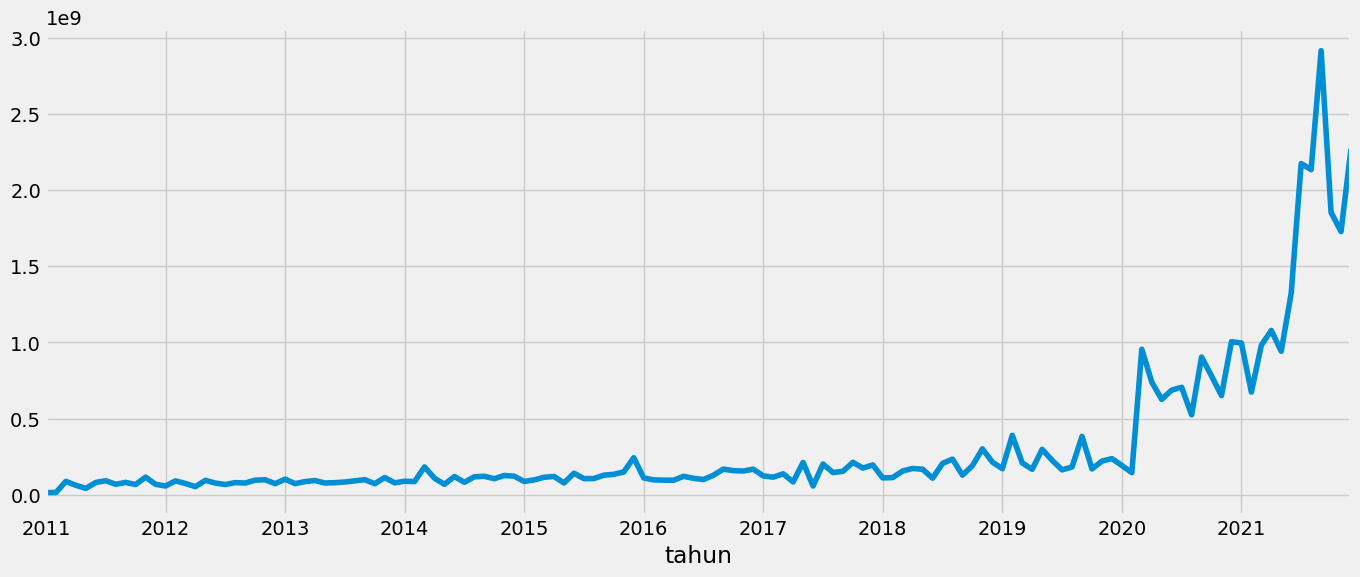

In [4]:
dts = pd.Series(data=df['jml_setor'].values, index=df['tahun'])
dts.plot(figsize=(15, 6))
plt.show()

# Mencari parameter terbaik ARIMA p, d, q

In [17]:
# Tentukan parameter p, d, dan q untuk mengambil nilai antara 0 sampai 5
p = d = q = range(0, 2)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
# Hasilkan semua kombinasi berbeda dari triplet p, q, dan q musiman
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [18]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
best_result = [0, 0, 10000000]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(dts,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=True,
                                            enforce_invertibility=True)
            results = mod.fit()
            if results.aic < best_result[2]:
                best_result = [param, param_seasonal, results.aic]
        except:
            continue
print('\nBest Result:', best_result)


Best Result: [(1, 1, 1), (1, 1, 0, 12), 4867.020365695007]


In [ ]:
 #order=(1, 0, 0),
  #                          seasonal_order=(0, 0, 0, 12),
  #                          enforce_stationarity=False,
    #                        enforce_invertibility=False)

# Plot model diagnostics

In [6]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
mod = sm.tsa.statespace.SARIMAX(dts,order=(1, 1, 1),seasonal_order=(1, 1, 0, 12),
                            enforce_stationarity=False,enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  132
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 12)   Log Likelihood               -2169.650
Date:                             Wed, 28 Dec 2022   AIC                           4347.301
Time:                                     07:32:00   BIC                           4357.955
Sample:                                 01-01-2011   HQIC                          4351.619
                                      - 12-01-2021                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4714      0.196      2.401      0.016       0.087       0.856
ma.L1         -0.7280      

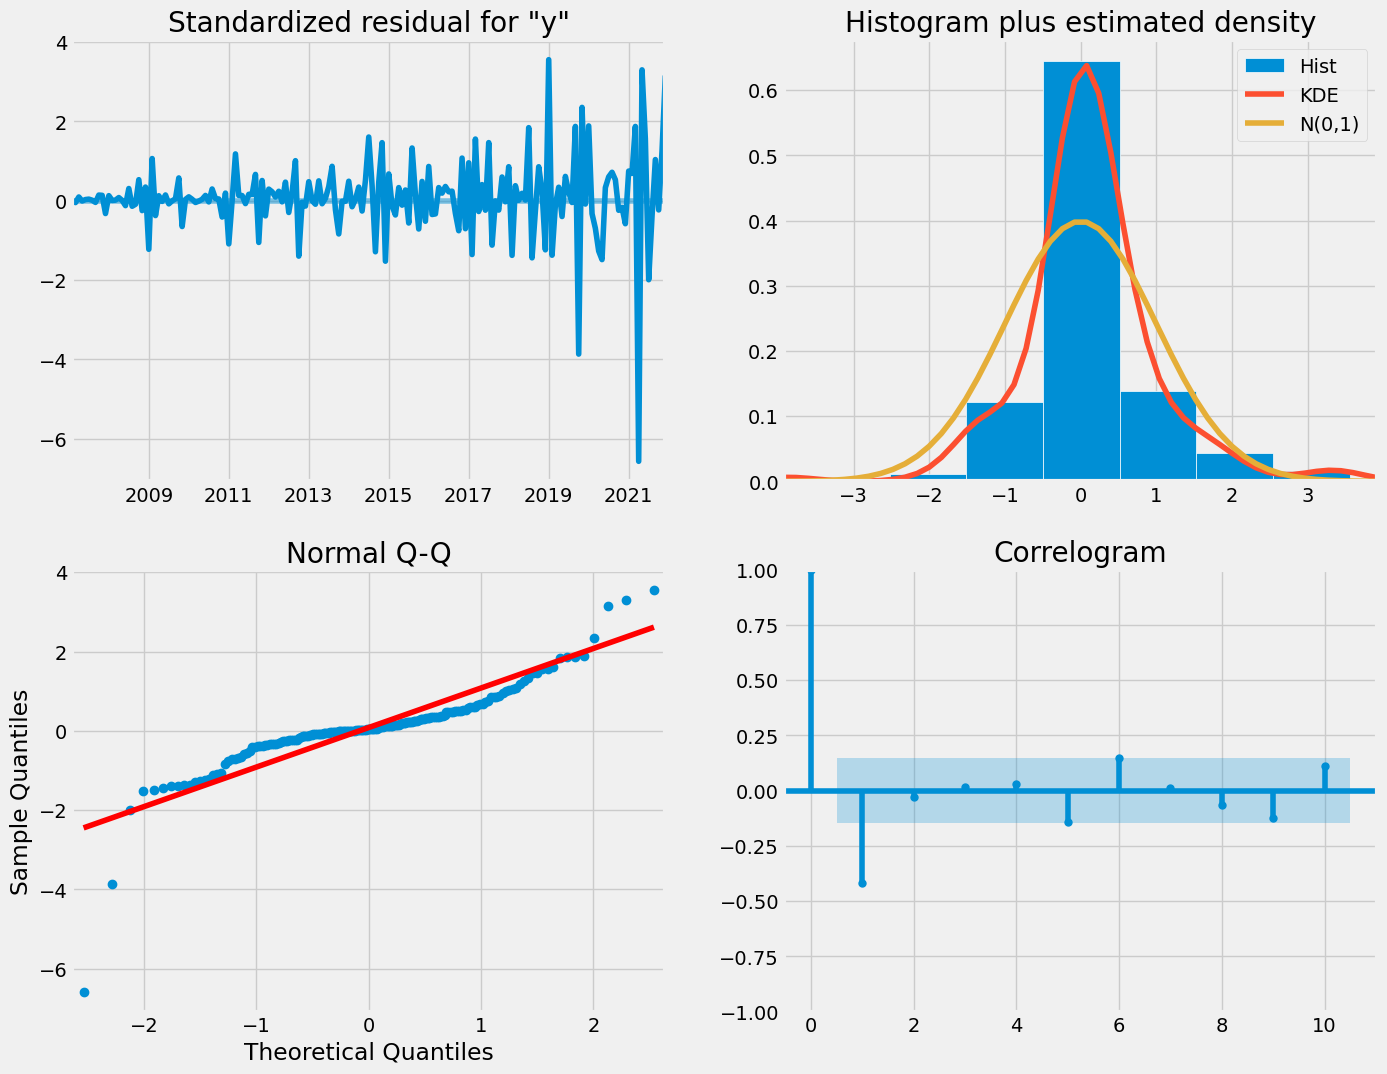

In [15]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

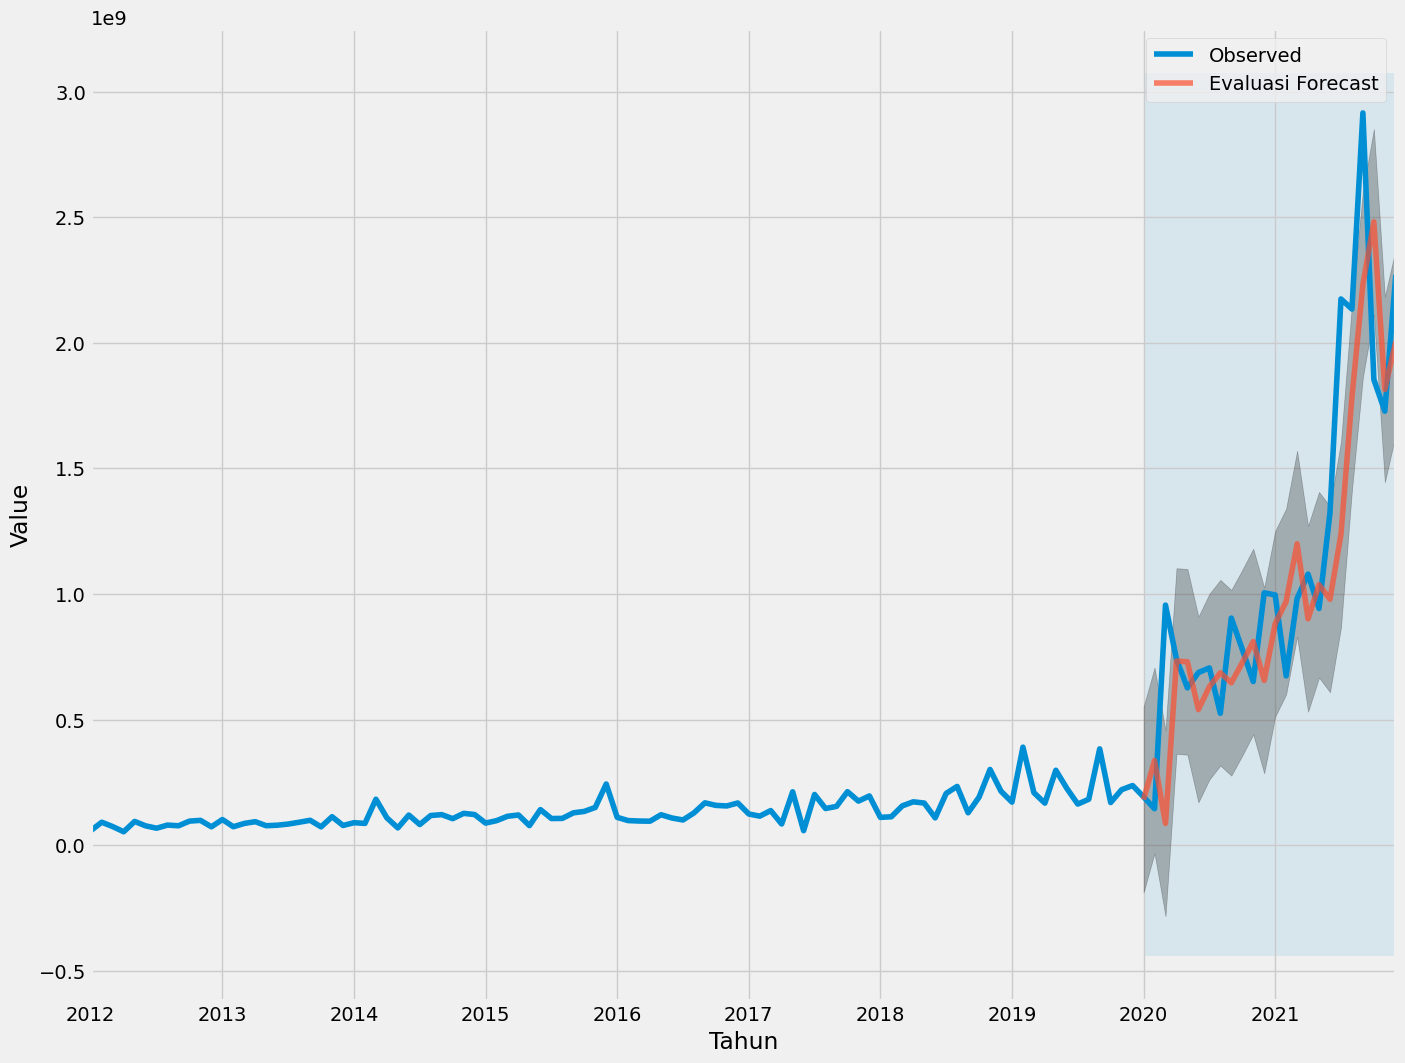

In [20]:
pred = results.get_prediction(start=pd.to_datetime('2020-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = dts['2012':].plot(label='Observed', figsize=(15, 12))
pred.predicted_mean.plot(ax=ax, label='Evaluasi Forecast', alpha=.7)
ax.fill_between(pred_ci.index,pred_ci.iloc[:, 0],pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2020-01-01'), dts.index[-1],alpha=.1, zorder=-1)
ax.set_xlabel('Tahun')
ax.set_ylabel('Value')
plt.legend()
plt.show()

# Prediksi data selama 2 tahun

In [8]:
# prediksi 24 langkah ke depan di masa mendatang
pred_uc = results.get_forecast(steps=60, dynamic=False)
# Dapatkan interval
pred_ci = pred_uc.conf_int()
json_data = pred_uc.predicted_mean.to_json(date_format='iso')
print(json_data)
with open('./datasets/airtanah_predicted.json', 'w') as f:
    json.dump(json_data, f) 

{"2022-01-01T00:00:00.000":2199090028.0350756645,"2022-02-01T00:00:00.000":1943831305.2120635509,"2022-03-01T00:00:00.000":2407268725.6863183975,"2022-04-01T00:00:00.000":2395385634.7560353279,"2022-05-01T00:00:00.000":2263660258.7291512489,"2022-06-01T00:00:00.000":2538264248.8422932625,"2022-07-01T00:00:00.000":3112172695.7590665817,"2022-08-01T00:00:00.000":3025048190.2416172028,"2022-09-01T00:00:00.000":3672755894.9515590668,"2022-10-01T00:00:00.000":2921970389.637134552,"2022-11-01T00:00:00.000":2795040303.5233793259,"2022-12-01T00:00:00.000":3274900318.9905228615,"2023-01-01T00:00:00.000":3224279318.9405965805,"2023-02-01T00:00:00.000":2946727270.9657349586,"2023-03-01T00:00:00.000":3358589982.9158430099,"2023-04-01T00:00:00.000":3382878462.3502831459,"2023-05-01T00:00:00.000":3249495351.4530978203,"2023-06-01T00:00:00.000":3559862132.9044981003,"2023-07-01T00:00:00.000":4225455245.0478858948,"2023-08-01T00:00:00.000":4153851207.6767158508,"2023-09-01T00:00:00.000":4845823373.680

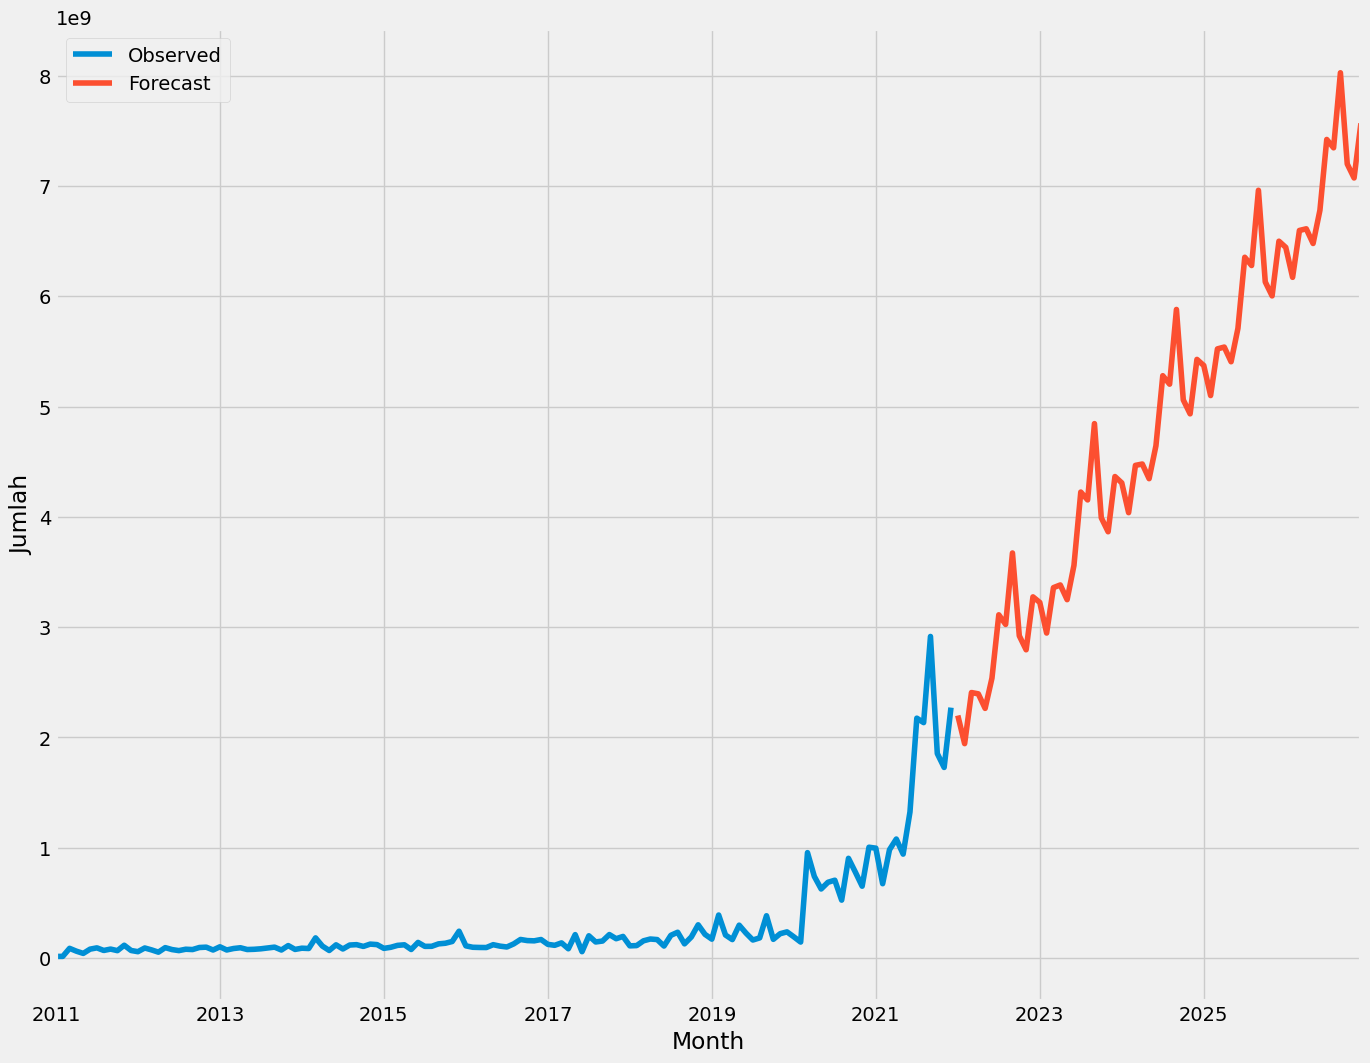

In [9]:
ax = dts.plot(label='Observed', figsize=(15, 12))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.set_xlabel('Month')
ax.set_ylabel('Jumlah')
plt.legend()
plt.show()